---
layout: post
title:  "A visual tutorial of Rejection Sampling"
desc: "Von Neumann rejection sampling explained with Python and animations."
date: 2020-06-16
categories: [tutorial]
tags: [statistics]
loc: 'tutorials/rejection_sampling/'
permalink: /tutorials/rejection_sampling
math: true
---

!!!replace

Rejection sampling is the conceptually simplest way to generate samples of some arbitrary probability function without having to do any transformations. No integration, no trickery, you simply trade computational efficiency away to keep everything as simple as possible.

Let's pick a super simple example: let's say you want to sample from the function

$$ f(x) = 1.2 - x^4 $$ 

between 0 and 1. It just happens this does integrate to 1, what luck! Let's visualise this function very quickly:

In [3]:
# Remove
from base import *
plt.rcParams['axes.prop_cycle'] = (
    cycler(color=['#003049', '#D62828', '#F77F00', '#FCBF49', '#EAE2B7']) + 
    cycler(linestyle=['-', '--', ':', '-.', '-']))

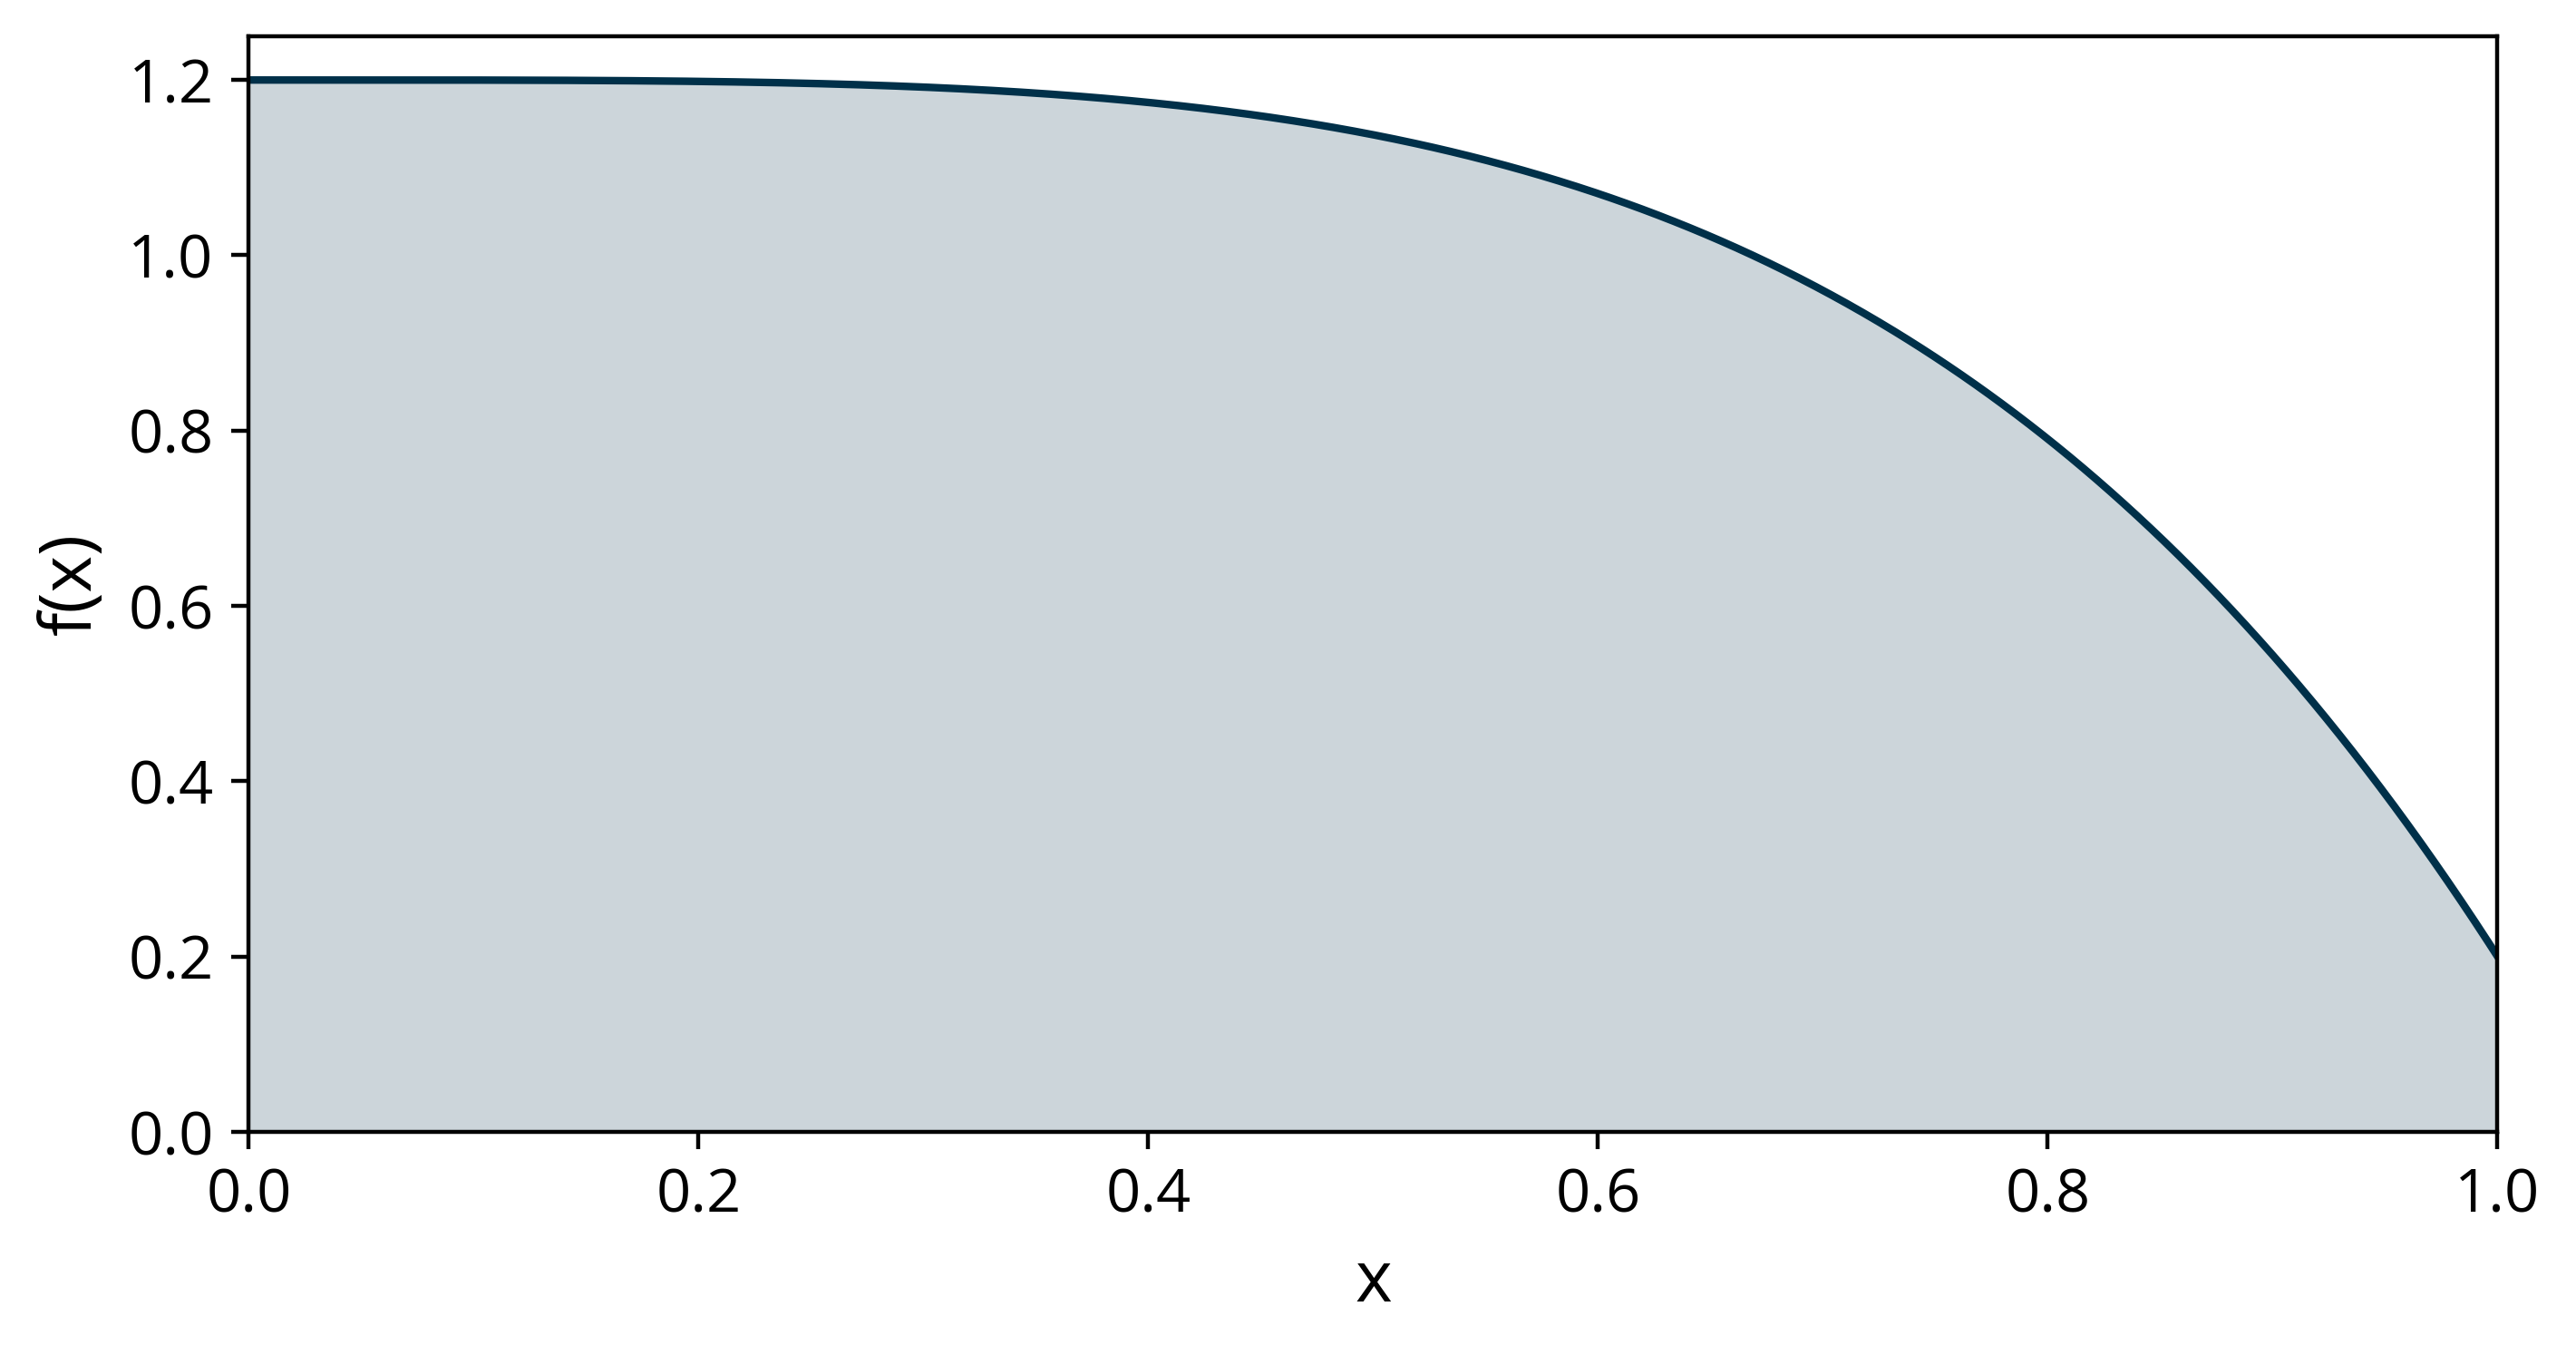

In [84]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return 1.2 - x**4

xs = np.linspace(0, 1, 1000)
ys = f(xs)

plt.plot(xs, ys), 
plt.fill_between(xs, ys, 0, alpha=0.2)
plt.xlim(0, 1), plt.ylim(0, 1.25), plt.xlabel("x"), plt.ylabel("f(x)");

We can see the function we care about goes from 0 to 1 in the x-axis, and 0 to 1.2 in the y-axis. So to sample from it using rejection sampling is simple:

1. Pick two random numbers. One for $x$ (between 0 and 1), one for $y$ (between 0 and 1.2).
2. If the $y$ value we randomly picked is less than $f(x)$, keep it, otherwise go back to step 1.

Simple! Play the animation below to see this in action!

In [90]:
%%manim rejection -r 500,1000 --high_quality

class PlotDashed(GraphScene):
    CONFIG = {
        "y_max" : 1.25,
        "y_min" : 0,
        "x_max" : 1,
        "x_min" : 0,
        "y_tick_frequency" : 0.2,
        "x_tick_frequency" : 0.2,
        "axes_color" : DARK_GREY,
        "y_label_direction": LEFT,
        "x_label_direction": UP,
        "x_labeled_nums": np.linspace(0, 1, 6),
        "y_labeled_nums": np.linspace(0, 1, 6),
        "camera_config": {"background_color": "#FFFFFF"},
        "font": 'sans-serif'
    }
    def construct(self):
        np.random.seed(0)
        func = lambda x : 1.2 - x**4
        self.setup_axes(animate=True)
        graph = self.get_graph(func, color=BLUE, x_min=0, x_max=1)
        self.play(ShowCreation(graph))
        for i in range(1, 20):
            self.add_point(func, i)
            if i == 2:
                self.wait(0.5)
        self.wait(4)
        
    def add_point(self, func, n):
        dots = []
        labels = []
        for i in range(n):
            x = np.random.random()
            if n == 1:
                x = 0.5
            elif n == 2 and i == 1:
                x = 0.95
            y = np.random.random() * 1.2
            passed = y < func(x)
            t = "Passed" if passed else "Rejected"
            c = GREEN if passed else RED
            coord = self.coords_to_point(x, y)
            dot = Dot(point=coord, color=c)
            text = Text(f"{t}", color=c, stroke_width=0).set_height(0.2).next_to(coord, DOWN)
            dots.append(dot)
            labels.append(text)
            
        vdots = VGroup(*dots)
        vlabels = VGroup(*labels)
        if n < 3:
            self.play(ShowCreation(vdots), ShowCreation(vlabels))
        else:
            self.play(ShowCreation(vdots))

So you can see that the reason this is so straightforward is that we get samples according to the function by simply throwing away the right number of samples when the function has a smaller value. In our function, this means if we get a small $x$ value, we'd normally keep the sample (and indeed the distribution is pretty flat for $x<0.5$), but for values close to $x=1$, we'd throw them out most of the time!

Let's write a very simple function that gets us a single sample using this method. See how for rejection sampling, you have to specify an initial box to pick from (the x bounds and the maximum y bound). This does make the algorithm unsuited for distributions that have an infinite range of $x$ values, a pity!

In [25]:
def sample(function, xmin=0, xmax=1, ymax=1.2):
    while True:
        x = np.random.uniform(low=xmin, high=xmax)
        y = np.random.uniform(low=0, high=ymax)
        if y < function(x):
            return x

Let us use this inefficient algorithm to generate a ten thousand samples, and plot their distribution to make sure it looks like its working

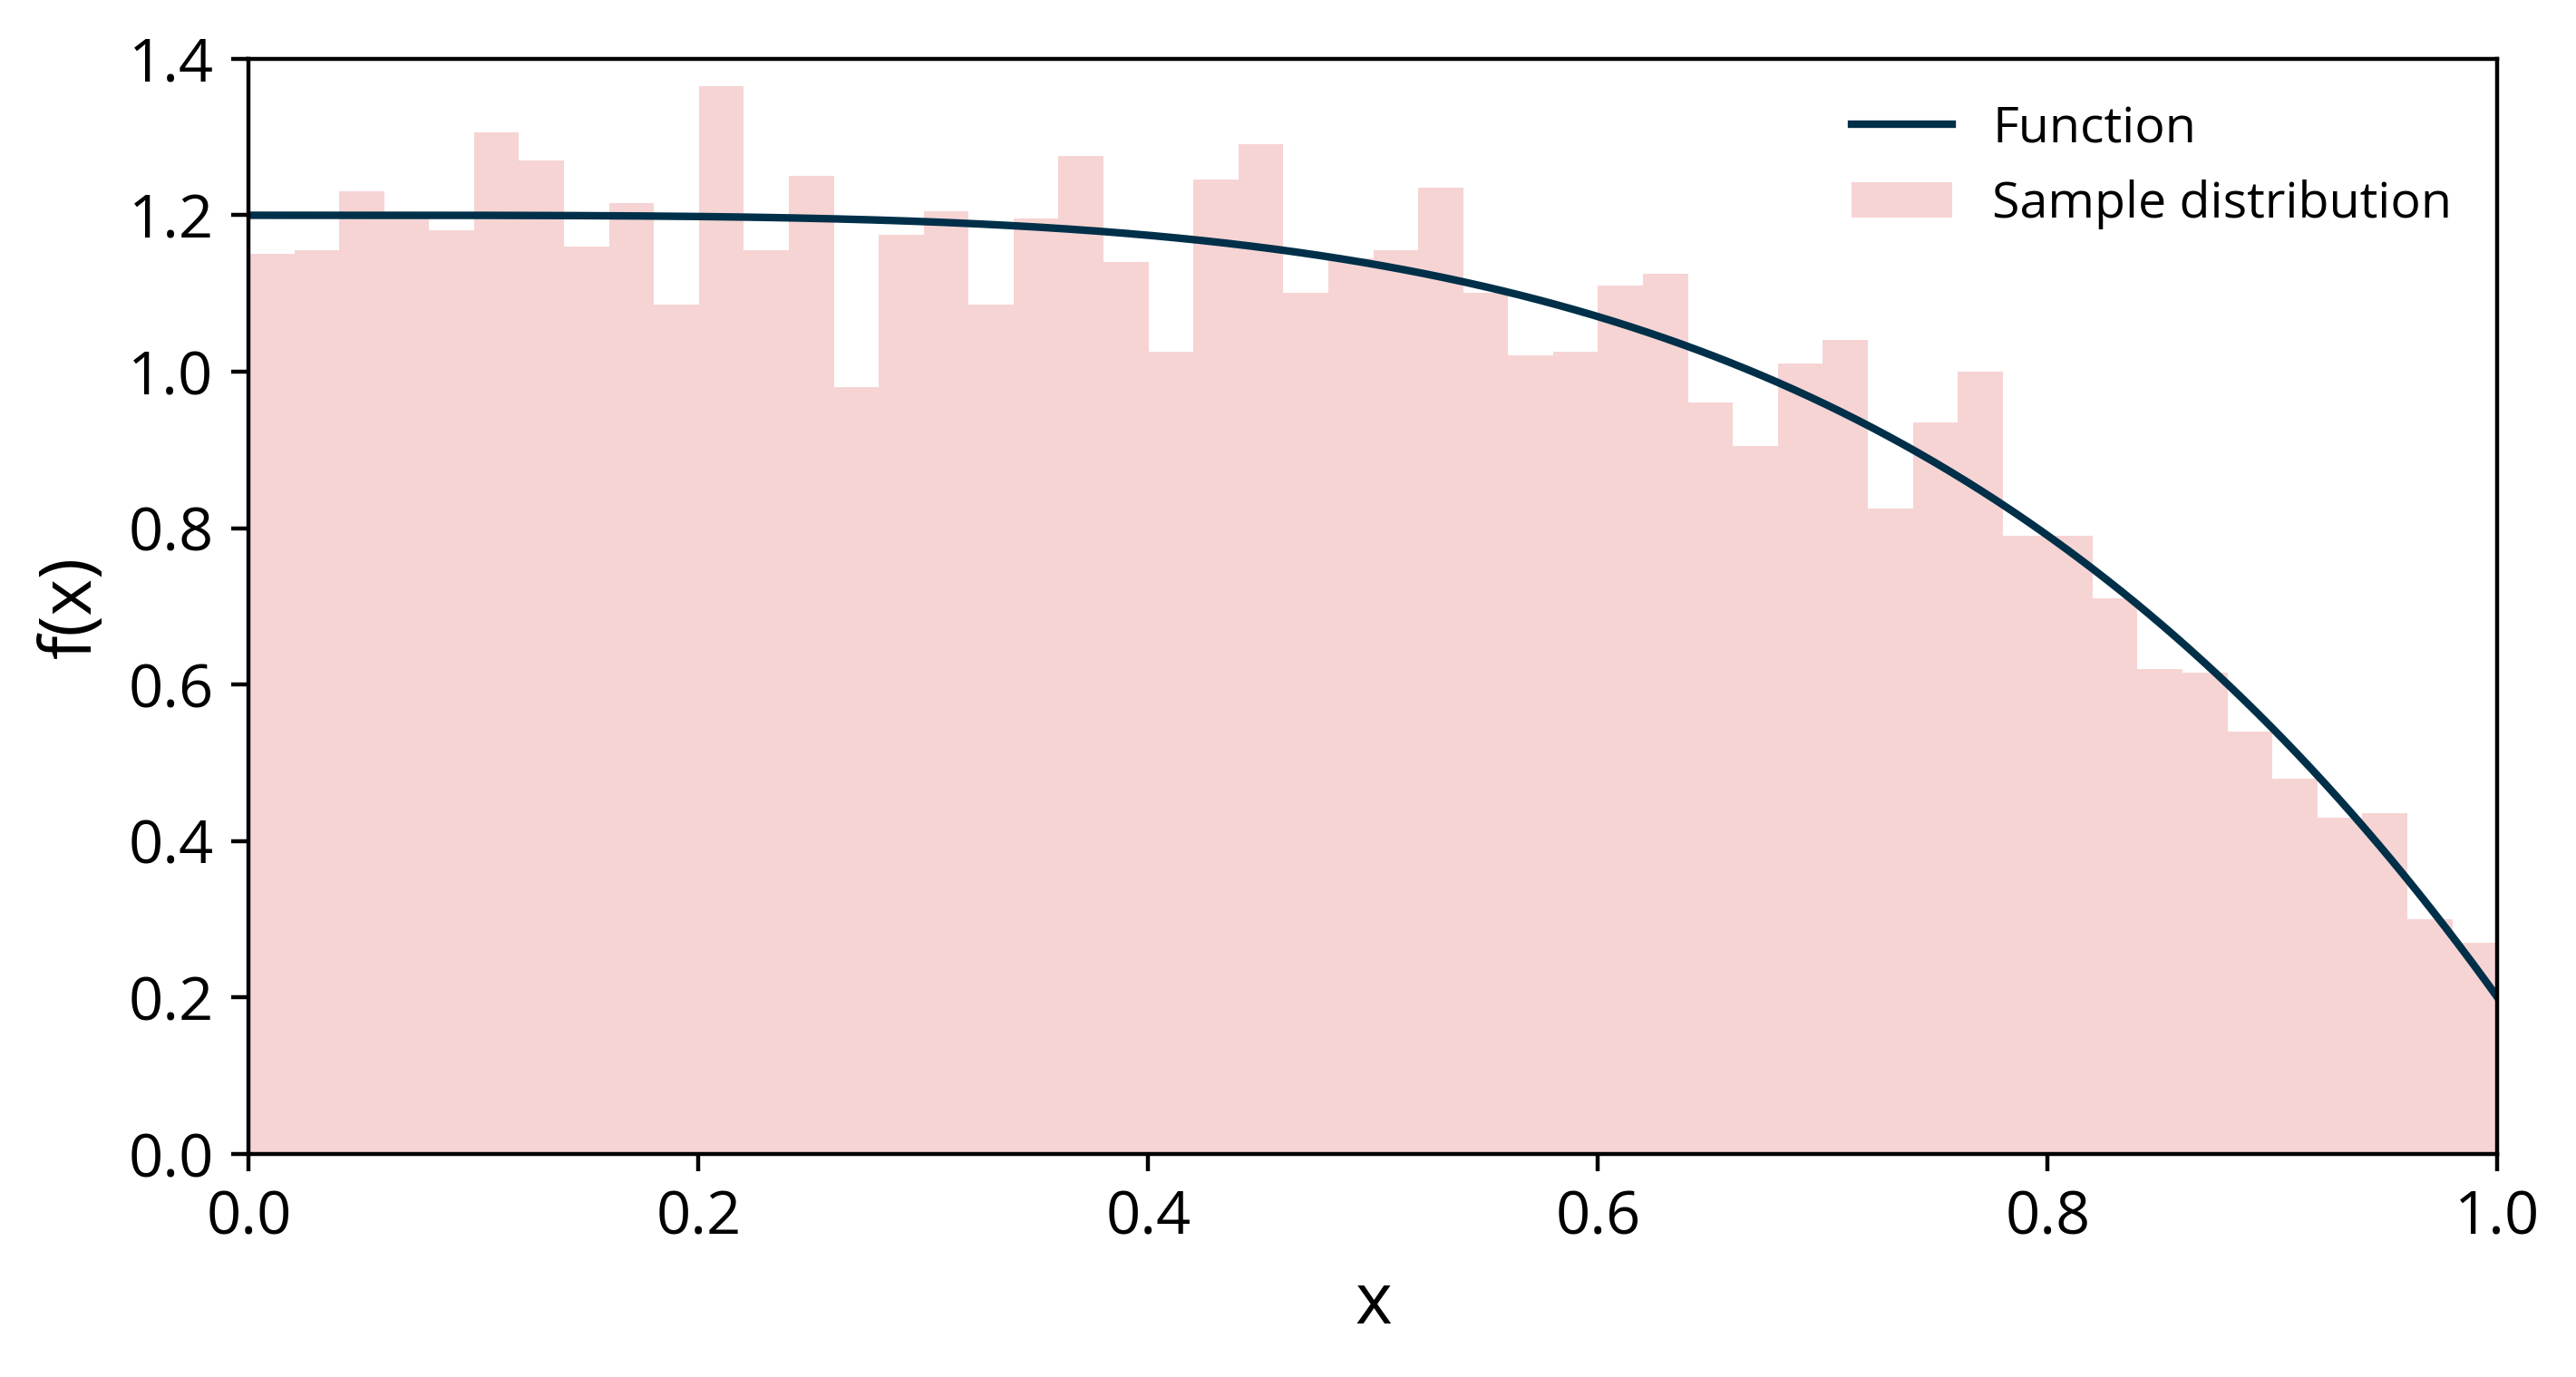

In [86]:
samps = [sample(f) for i in range(10000)]

plt.plot(xs, ys, label="Function")
plt.hist(samps, density=True, alpha=0.2, label="Sample distribution")
plt.xlim(0, 1), plt.ylim(0, 1.4), plt.xlabel("x"), plt.ylabel("f(x)"), plt.legend();

Hurray, a working algorithm! Of course, this is incredibly slow, because we're asking for things one at a time. Let's improve that slowly and do batches of 1000 proposals at once.

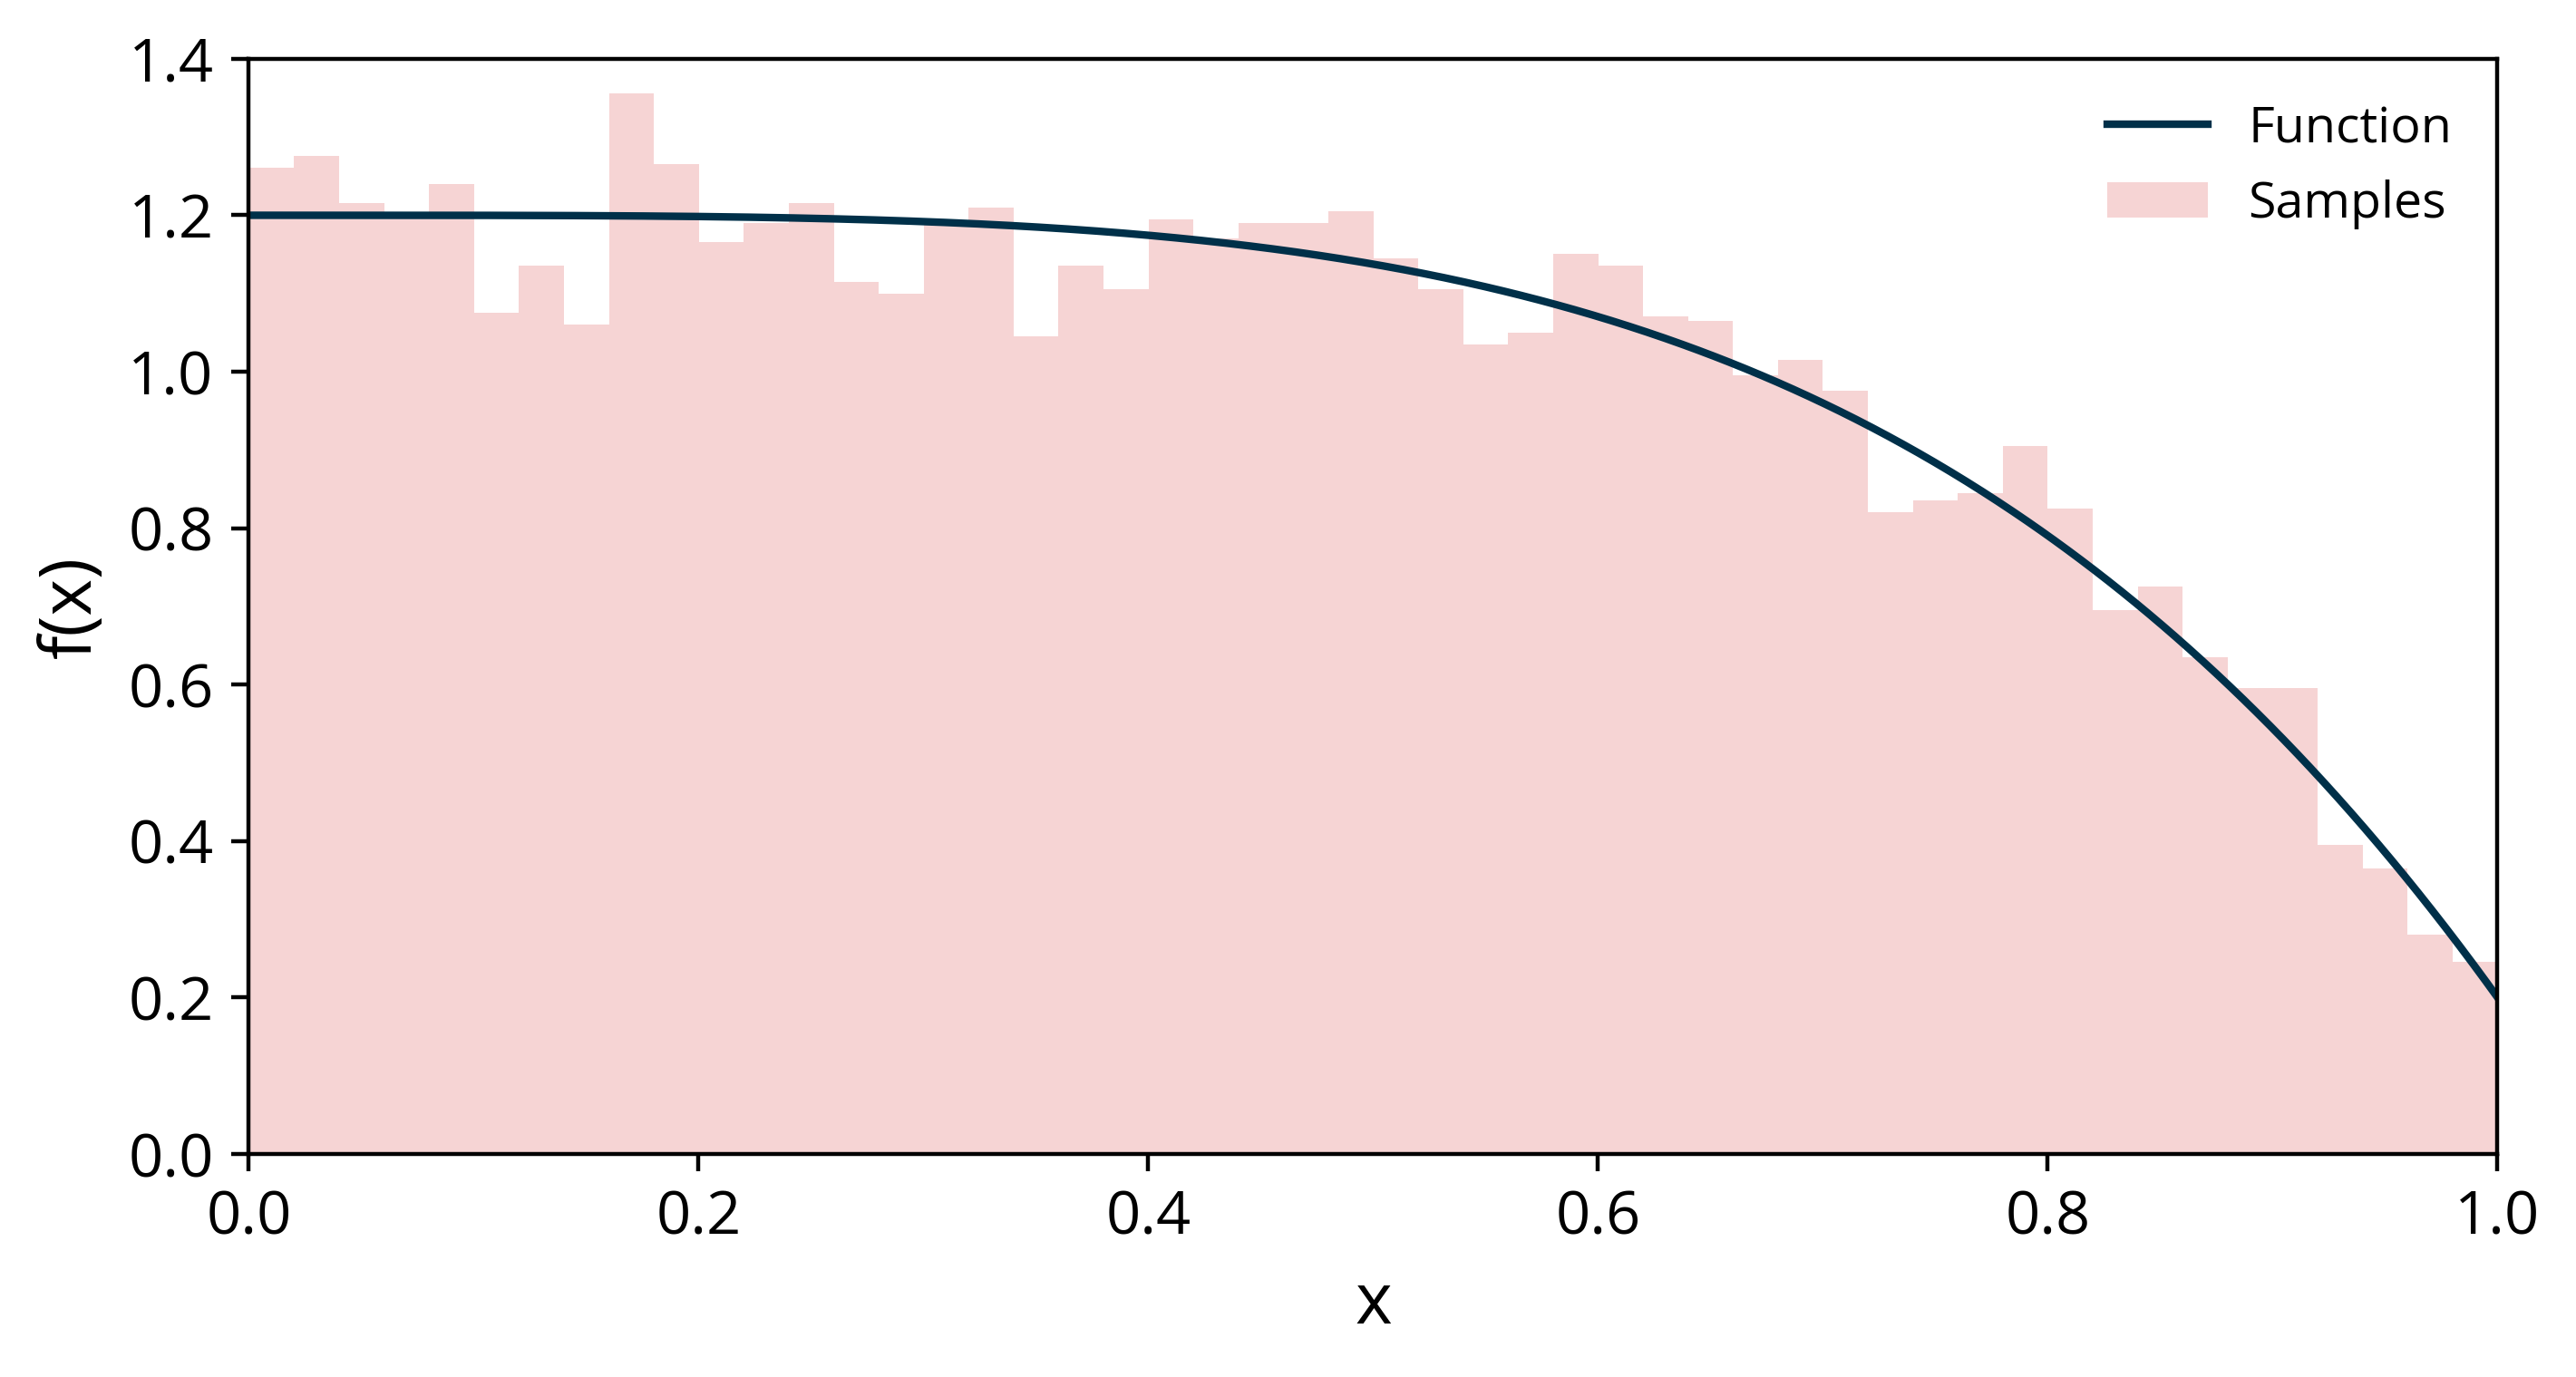

In [85]:
def batch_sample(function, num_samples, xmin=0, xmax=1, ymax=1.2, batch=1000):
    samples = []
    while len(samples) < num_samples:
        x = np.random.uniform(low=xmin, high=xmax, size=batch)
        y = np.random.uniform(low=0, high=ymax, size=batch)
        samples += x[y < function(x)].tolist()
    return samples[:num_samples]

samps = batch_sample(f, 10000)

plt.plot(xs, ys, label="Function")
plt.hist(samps, density=True, alpha=0.2, label="Sample distribution")
plt.xlim(0, 1), plt.ylim(0, 1.4), plt.xlabel("x"), plt.ylabel("f(x)"), plt.legend();

Whats the speed difference you ask?

In [35]:
%timeit [sample(f) for i in range(10000)]

64.2 ms ± 1.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
%timeit batch_sample(f, 10000)

1.12 ms ± 4.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


64 milliseconds down to 1 millisecond. And we could go even lower if we stop turn numpy arrays into lists and concatenating them, but you get the idea. You may be wondering why we didn't just do it all in one go, why break it into batches. Turns out there is a sweet spot for generating vectors - too small and you waste too much time creating them, too big and things start to slow down as well. 1000 is definitely not the sweet spot, but its sweeter than nothing!

## The compromises for rejection sampling

We've already touched on the compromises of rejection sampling - inefficiency. Imagine instead of having this beautiful bound function between 0 and 1, we instead want to sample a Gaussian distribution like such:

$$ f(x) = e^{-\pi x^2} $$

This is defined over all $x$ values, and $\int_{-\infty}^{\infty} e^{-\pi x^2} = 1$, so it's a proper, normalised probability density function alright. What if we want to make sure that our sampling method can capture even extreme outliers?

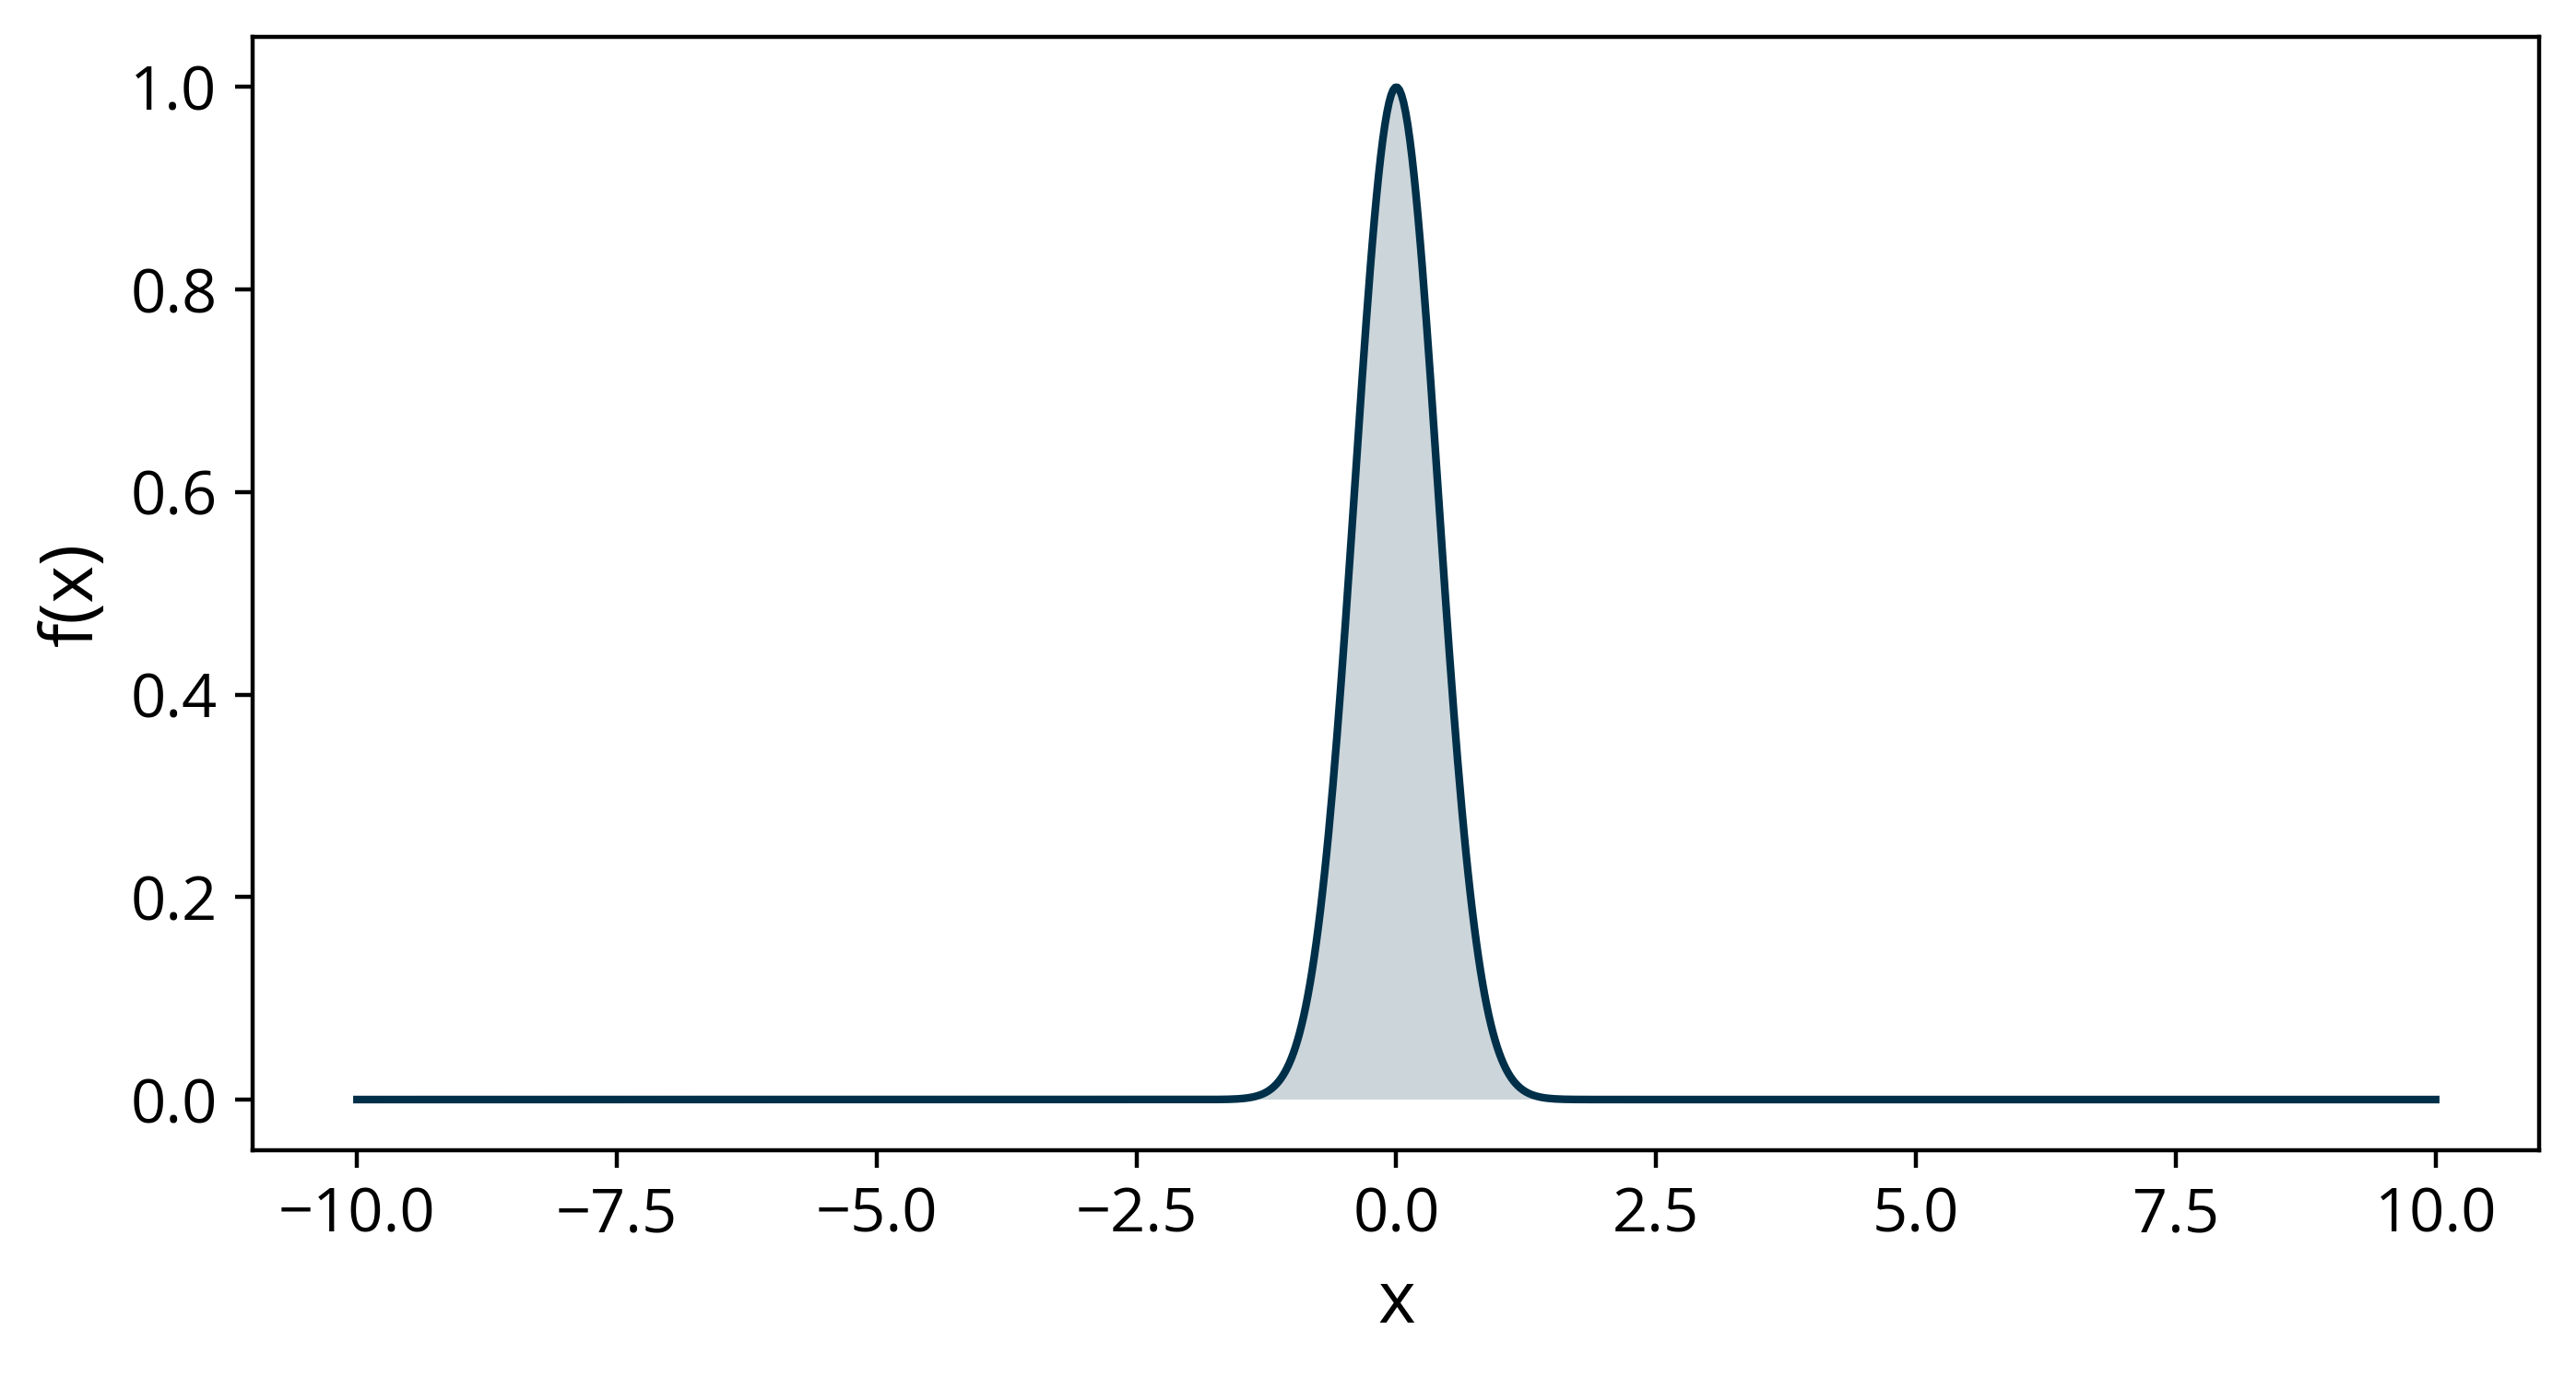

In [88]:
def gauss(x):
    return np.exp(-np.pi * x**2)

xs = np.linspace(-10, 10, 1000)
ys = gauss(xs)

plt.plot(xs, ys)
plt.fill_between(xs, ys, 0, alpha=0.2)
plt.xlabel("x"), plt.ylabel("f(x)");

Theres an awful lot of white space on that plot. Let's modify our batch sample function to just do a certain number of samples, but return whether they passed or failed.

Efficiency is only 4.8%


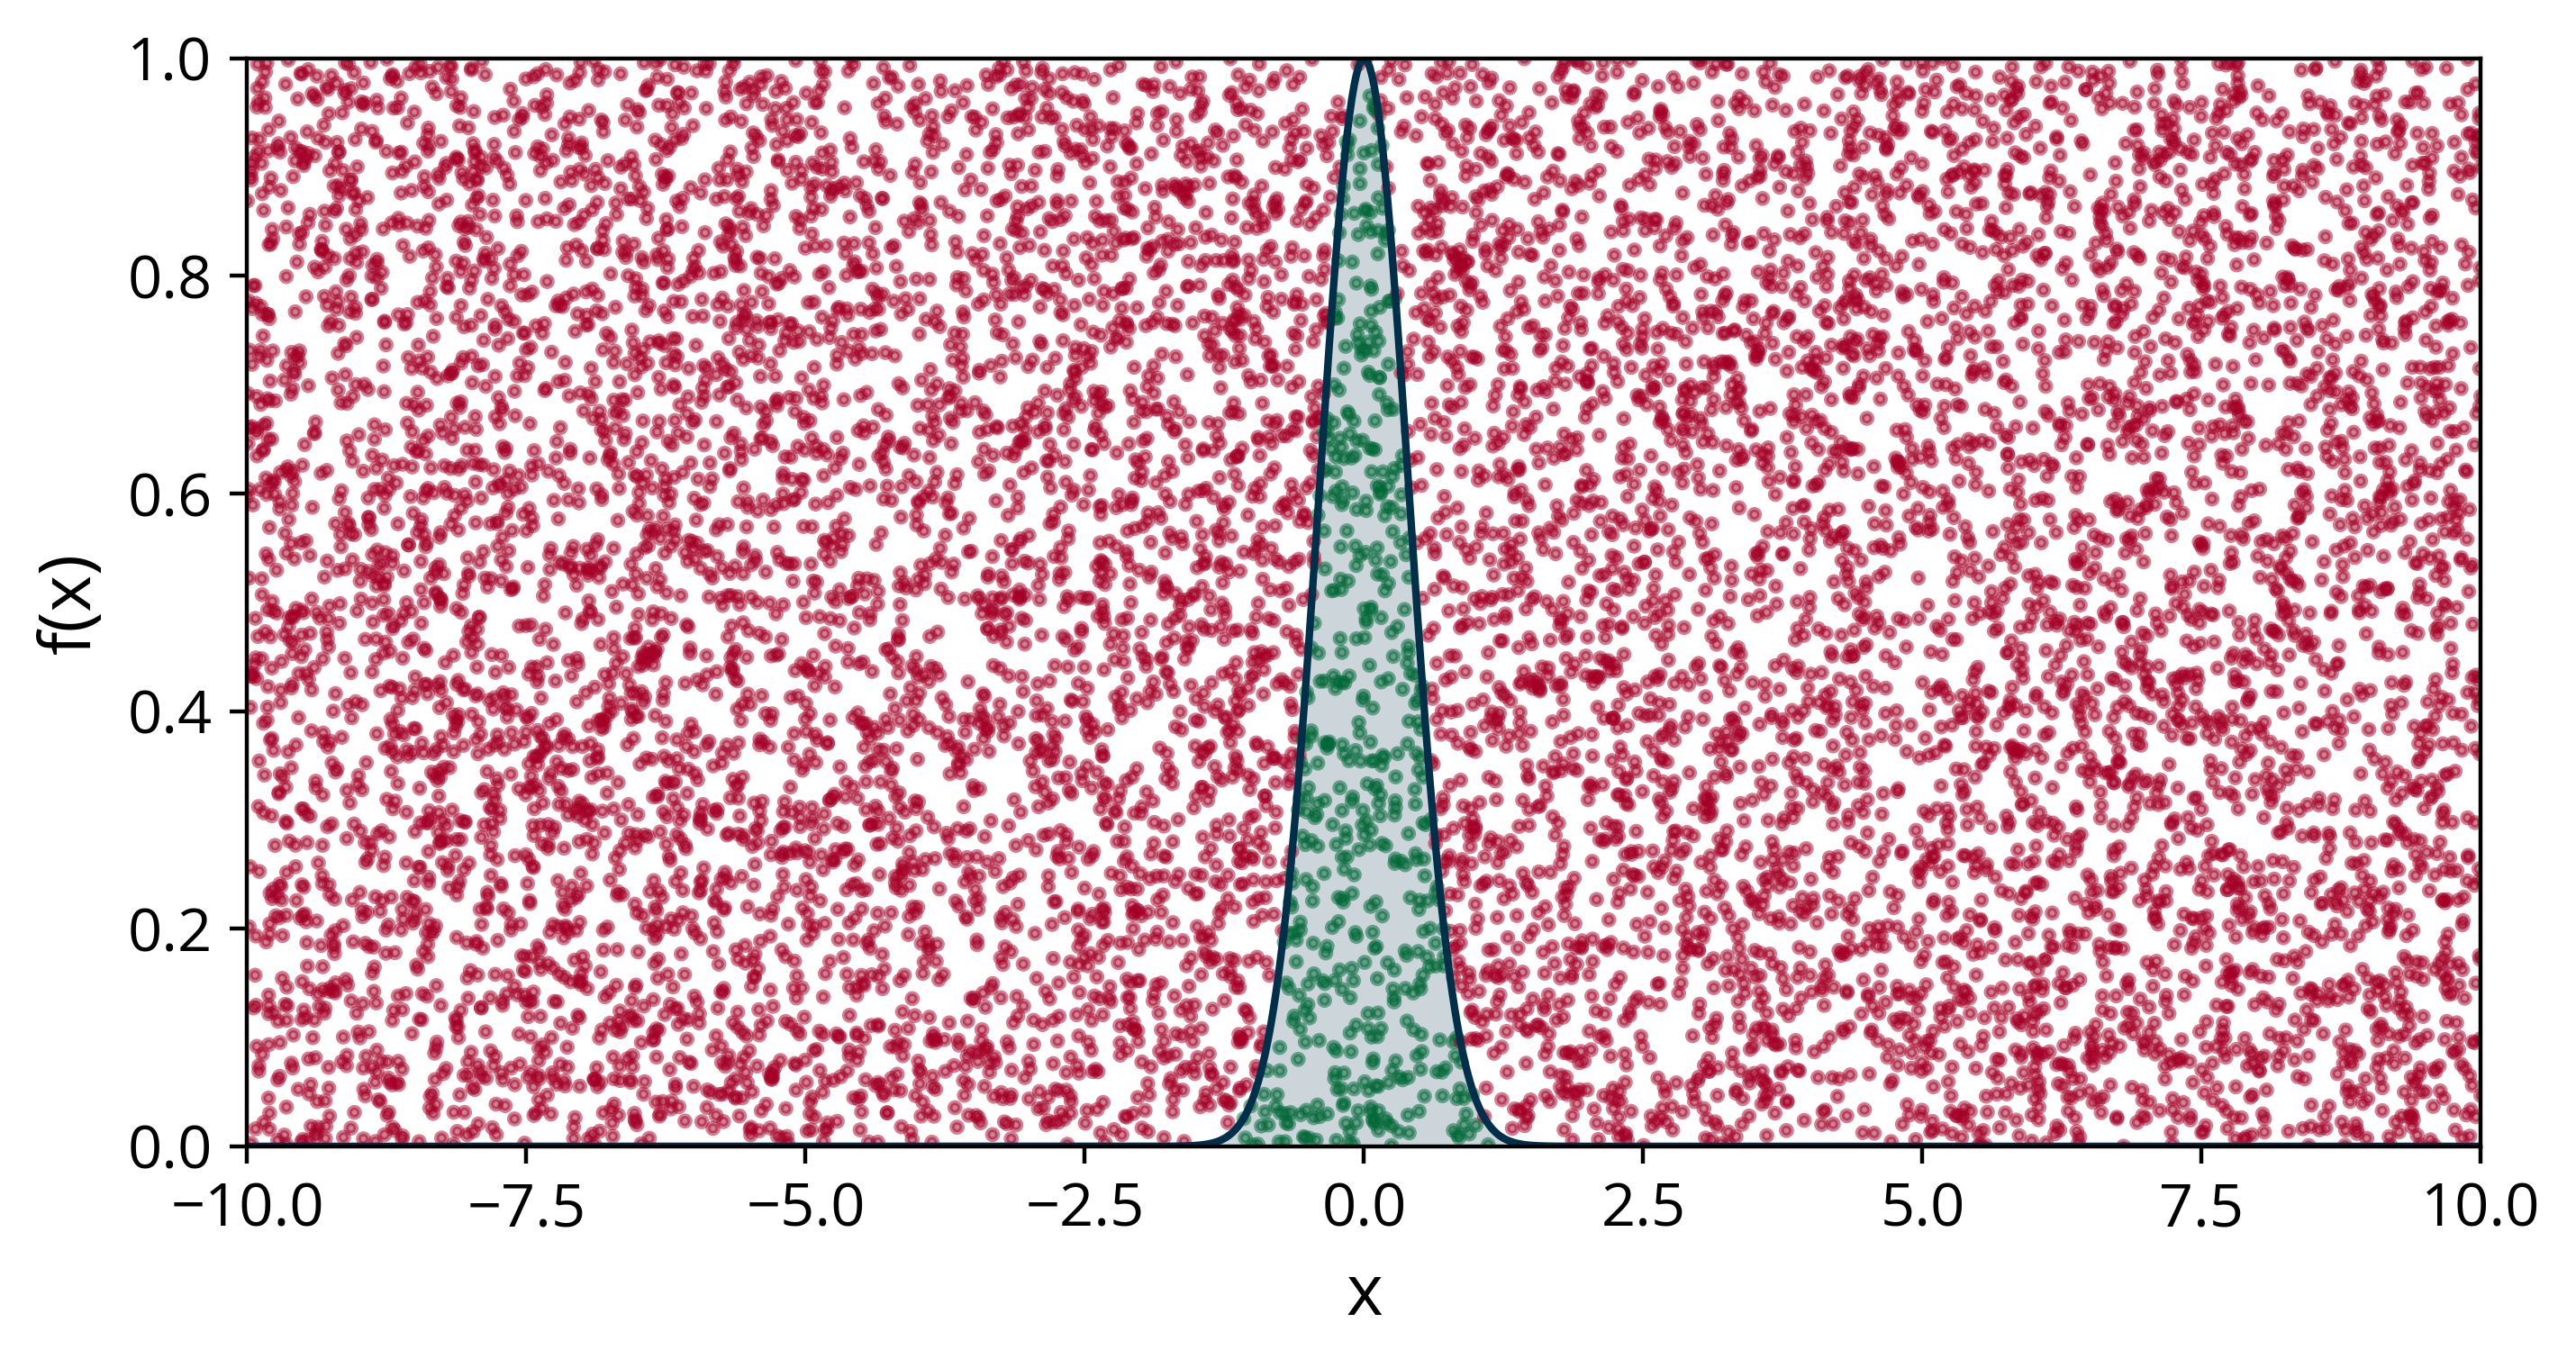

In [89]:
def batch_sample_2(function, num_samples, xmin=-10, xmax=10, ymax=1):
    x = np.random.uniform(low=xmin, high=xmax, size=num_samples)
    y = np.random.uniform(low=0, high=ymax, size=num_samples)
    passed = (y < function(x)).astype(int)
    return x, y, passed

x, y, passed = batch_sample_2(gauss, 10000)

plt.plot(xs, ys)
plt.fill_between(xs, ys, 0, alpha=0.2)
plt.scatter(x, y, c=passed, cmap="RdYlGn", alpha=0.5)
plt.xlabel("x"), plt.ylabel("f(x)"), plt.xlim(-10, 10), plt.ylim(0, 1);

!!! print(f"Efficiency is only {passed.mean() * 100:0.1f}%")

!!!main

And you can see that we reject 19 out of 20 samples! Super inefficient, and it would only get worse if we set the x limits even wider. In principle, we'd them as narrow as we could without having to worry about seeing edges in our generated distributions.

Anyway, thats rejection sampling. Super simple!